In [1]:
import sys
sys.path.append('/lmh_data/work/SEE/train/')
sys.path.append('/lmh_data/work/SEE/analyse/')
import random

import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context

from util import array2mat

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
map_info = pd.read_csv('/lmh_data/data/sclab/sclab/map_result.csv', sep='\t', index_col=0)
rna = anndata.read_h5ad("/lmh_data/data/sclab/Human_M1_10x/scRNA.h5ad")
rna.obs.cell_type = rna.obs.cell_type.cat.rename_categories({'Oligo': 'ODC'})

gene_name = 'PIP4K2A'
eval_set = np.load('/lmh_data/data/sclab/sclab/eval_dataset.npy', allow_pickle=True)
preds = np.load('/lmh_data/data/sclab/sclab/tmp/{}/evaluate.npy'.format(gene_name), allow_pickle=True)

In [3]:
rna = rna[map_info.index]
rna = rna[rna.obs['cell_type'].isin(['ODC']),:]
rna.layers["counts"] = rna.X.copy()

In [4]:
_index = []
_rna = rna[:, eval_set[0]['scRNA_head']]
_rna_counts = _rna.layers["counts"].astype(np.int32)
for i in range(len(preds)):
    if eval_set[i]['identity'] == 'fake':
        continue
#     if eval_set[i]['cell_type'] in ['Endo']:
#         continue
    if eval_set[i]['cell_type'] not in ['ODC']:
        continue
    for j in range(_rna.shape[0]):
        if (_rna_counts[j] == eval_set[i]['scRNA']).all():
            _index.append(_rna[j].obs.index[0])
            
rna = rna[_index]
rna

View of AnnData object with n_obs × n_vars = 230 × 50281
    obs: 'cell_type', 'domain'
    layers: 'counts'

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be

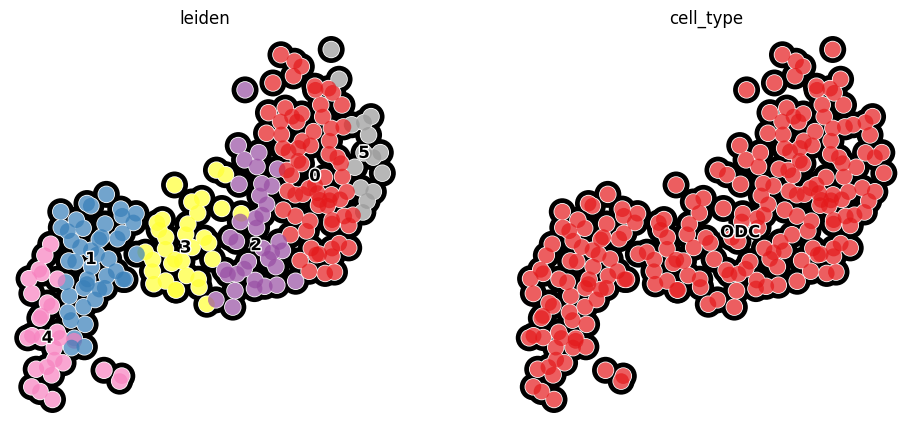

In [5]:
rna.X = rna.layers["counts"].copy()
# sc.pp.highly_variable_genes(rna, n_top_genes=2000, flavor="seurat_v3")
# sc.pp.normalize_total(rna)
# sc.pp.log1p(rna)
# sc.pp.scale(rna)
sc.tl.pca(rna, n_comps=100, svd_solver="auto")

sc.pp.neighbors(rna, metric="cosine")
sc.tl.umap(rna)
sc.tl.leiden(rna)

with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(rna, color=['leiden', 'cell_type'], add_outline=True, legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=2, frameon=False, palette='Set1')

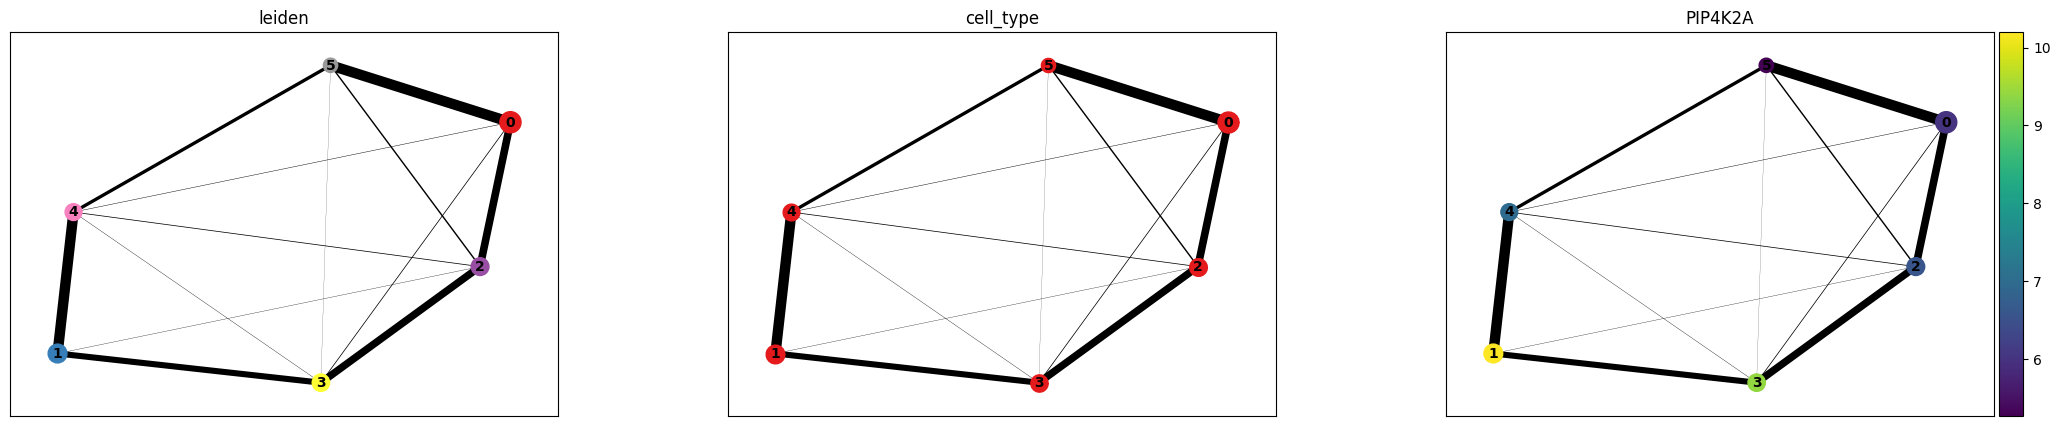

In [6]:
sc.tl.paga(rna, groups='leiden')
sc.pl.paga(rna, color=['leiden', 'cell_type', gene_name])

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


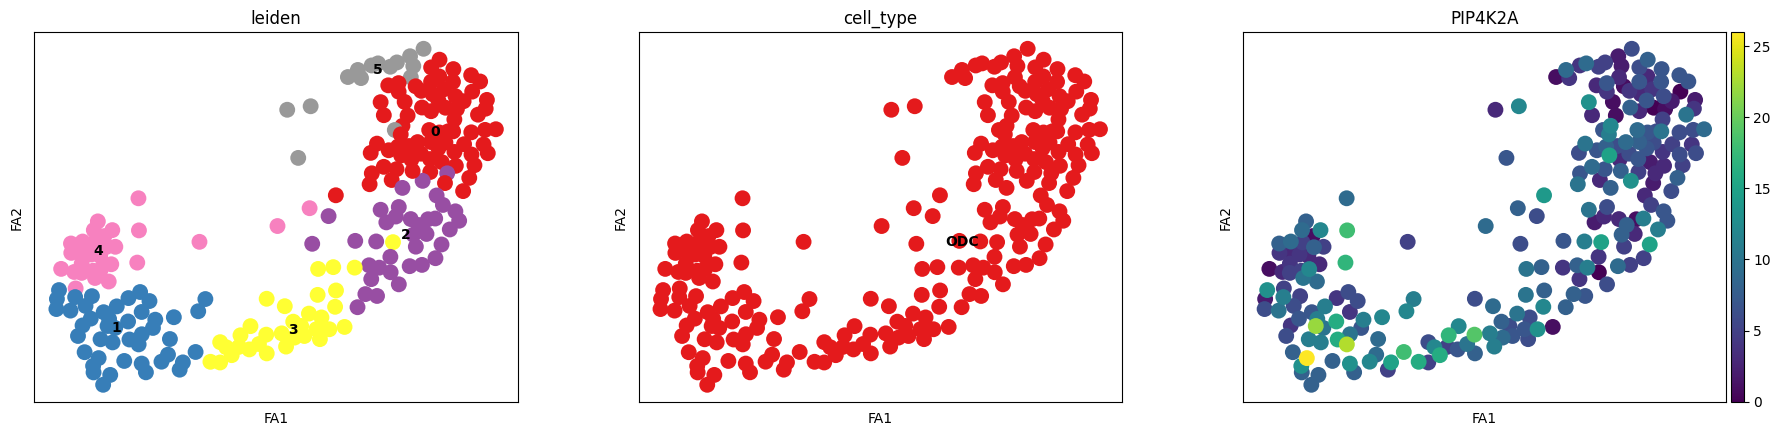

In [7]:
sc.tl.draw_graph(rna, init_pos='paga')
sc.pl.draw_graph(rna, color=['leiden', 'cell_type', gene_name], legend_loc='on data')

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


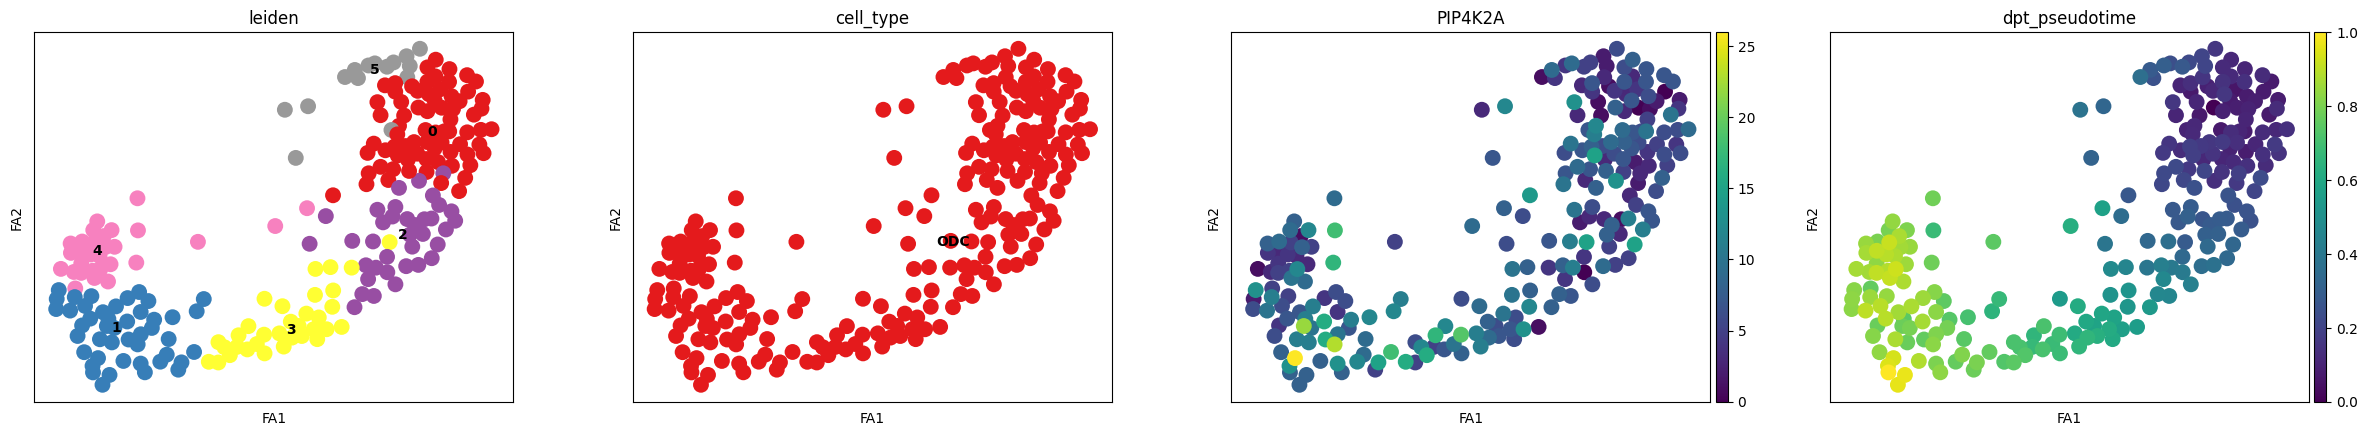

In [8]:
rna.uns['iroot'] = np.flatnonzero(rna.obs['leiden']=='0')[0]
sc.tl.dpt(rna)

sc.tl.draw_graph(rna, init_pos='paga')
sc.pl.draw_graph(rna, color=['leiden', 'cell_type', gene_name, 'dpt_pseudotime'], legend_loc='on data')

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


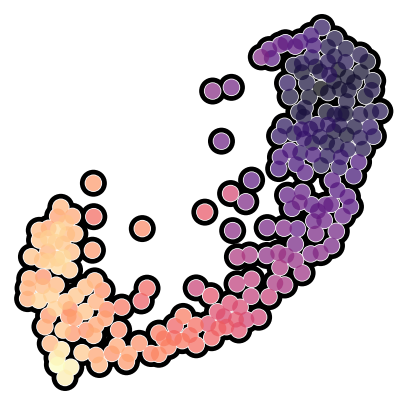

In [9]:
with rc_context({'figure.figsize': (5, 5)}):
    fig = sc.pl.draw_graph(rna, color=['dpt_pseudotime'], cmap='magma',
                     add_outline=True, legend_loc=None, colorbar_loc=None, title='', frameon=False, return_fig=True)
#     plt.savefig(
#         '/lmh_data/work/SEE/analyse/figure_file/pseudotime({}).pdf'.format(gene_name),
#         format='pdf', bbox_inches='tight')
    plt.show()

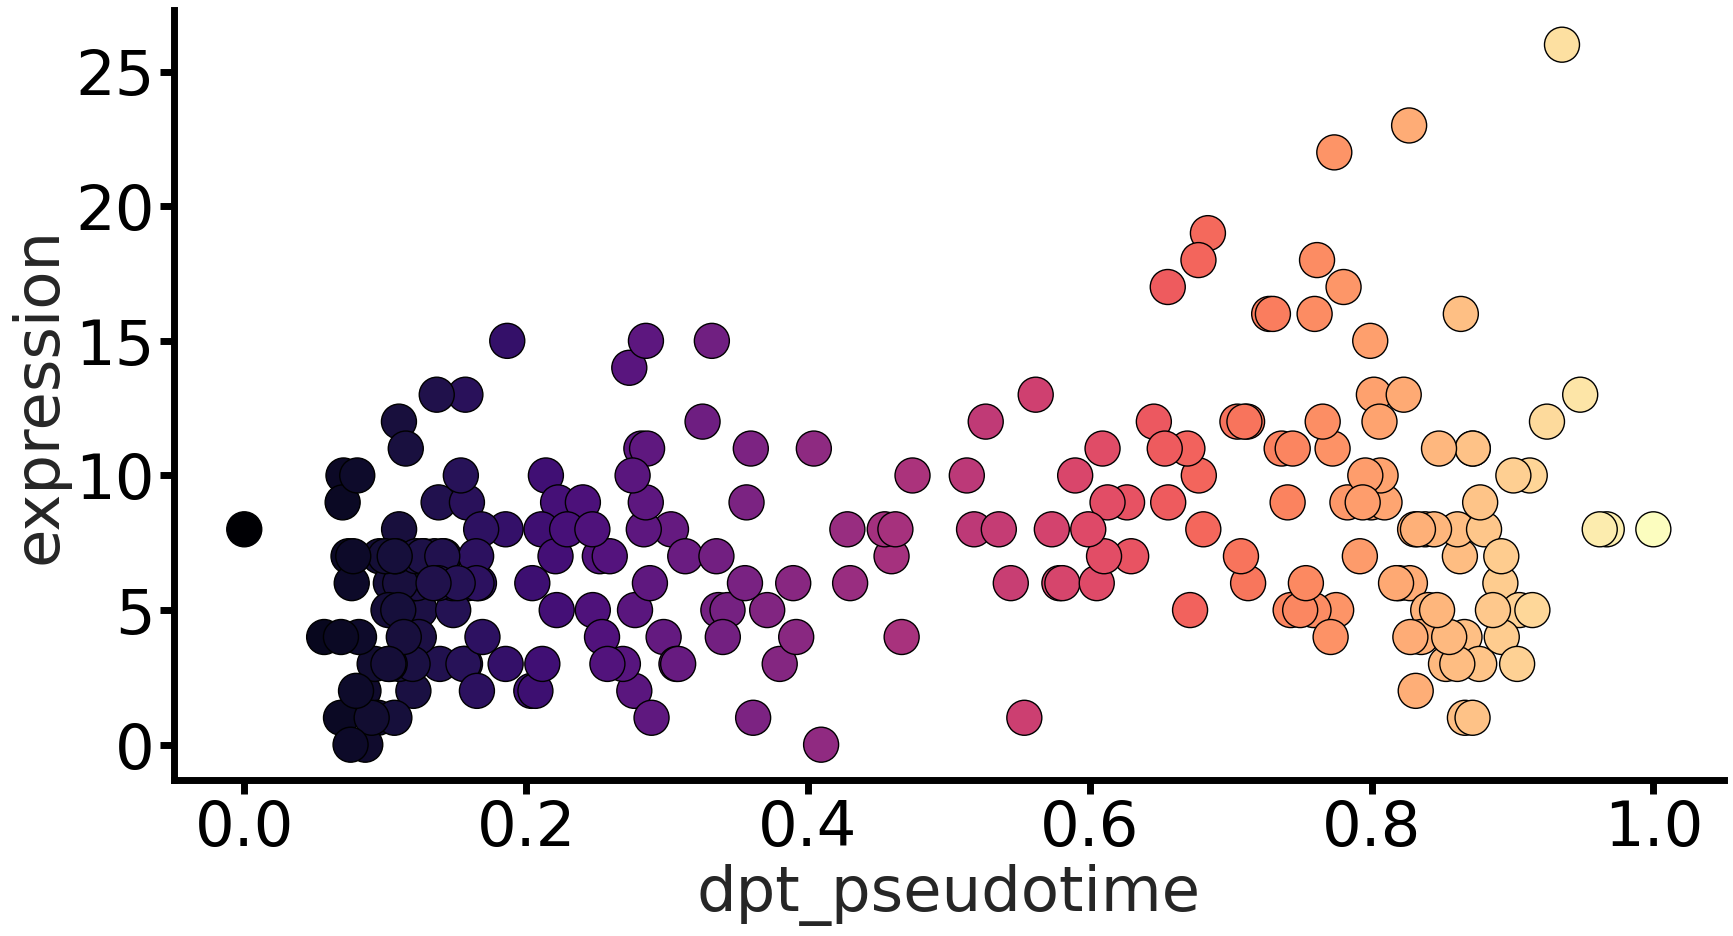

In [10]:
import seaborn as sns
from analyse_util import figure_size, set_plt, set_Border

set_plt(figsize=(20, 10))
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()

_x, _y = rna.obs['dpt_pseudotime'].values, rna[:, gene_name].layers["counts"].reshape(-1)
ax.scatter(_x, _y, edgecolors='black', s=(figure_size['large']*72./fig.dpi)**2, c=_x, cmap='magma')

set_Border(plt.gca())
plt.tick_params(colors='black', bottom=True, left=True, labelsize=figure_size['ultra'])
plt.grid(False)
plt.xlabel('dpt_pseudotime', fontsize=figure_size['ultra'])
plt.ylabel('expression', fontsize=figure_size['ultra'])
# plt.savefig(
#     '/lmh_data/work/SEE/analyse/figure_file/{} expression(ODC).pdf'.format(gene_name),
#     format='pdf', bbox_inches='tight')
plt.show()

In [11]:
scHiC = {}
_rna = rna[:, eval_set[0]['scRNA_head']]
_rna_counts = _rna.layers["counts"].astype(np.int32)
for i in range(len(preds)):
    if eval_set[i]['identity'] == 'fake':
        continue
    if eval_set[i]['cell_type'] not in ['ODC']:
        continue
    for j in range(_rna.shape[0]):
        if (_rna_counts[j] == eval_set[i]['scRNA']).all():
            scHiC[_rna[j].obs_names[0]] = preds[i]['predict']
            break
scHiC

{'CTAAGTGGTGTCCAAT-LKTX_190130_01_F01': array([ 3.54254991e-01,  2.98504848e-02, -1.12568606e-02,  8.92745331e-03,
        -1.05366483e-03,  2.18014084e-02,  3.90890241e-03, -1.87721103e-04,
         1.79662555e-02, -2.42057815e-03, -2.33738031e-03,  1.06296539e-02,
         1.73896179e-03,  1.07740052e-03, -7.17712753e-03,  4.88357805e-03,
        -8.42902344e-03,  1.70086939e-02, -6.17978722e-03,  4.15021479e-01,
         4.06831875e-03,  1.08711002e-02,  1.52479485e-03,  1.82208307e-02,
        -4.67731245e-03,  3.71443713e-03, -2.88468041e-03, -8.99627246e-03,
         1.14023574e-02, -2.12349333e-02, -3.98530811e-03,  4.18012589e-03,
         5.64931706e-03, -1.81068499e-02,  2.11221725e-02,  1.15448609e-03,
         2.29643658e-03,  4.56274986e-01, -9.55102965e-03,  1.83805134e-02,
        -2.07863897e-02, -2.90707499e-03,  1.69475600e-02,  4.42021713e-03,
        -8.17154720e-03,  5.42299077e-03, -6.38608634e-03,  1.10631883e-02,
         6.33556955e-03,  1.41001530e-02,  3.6356

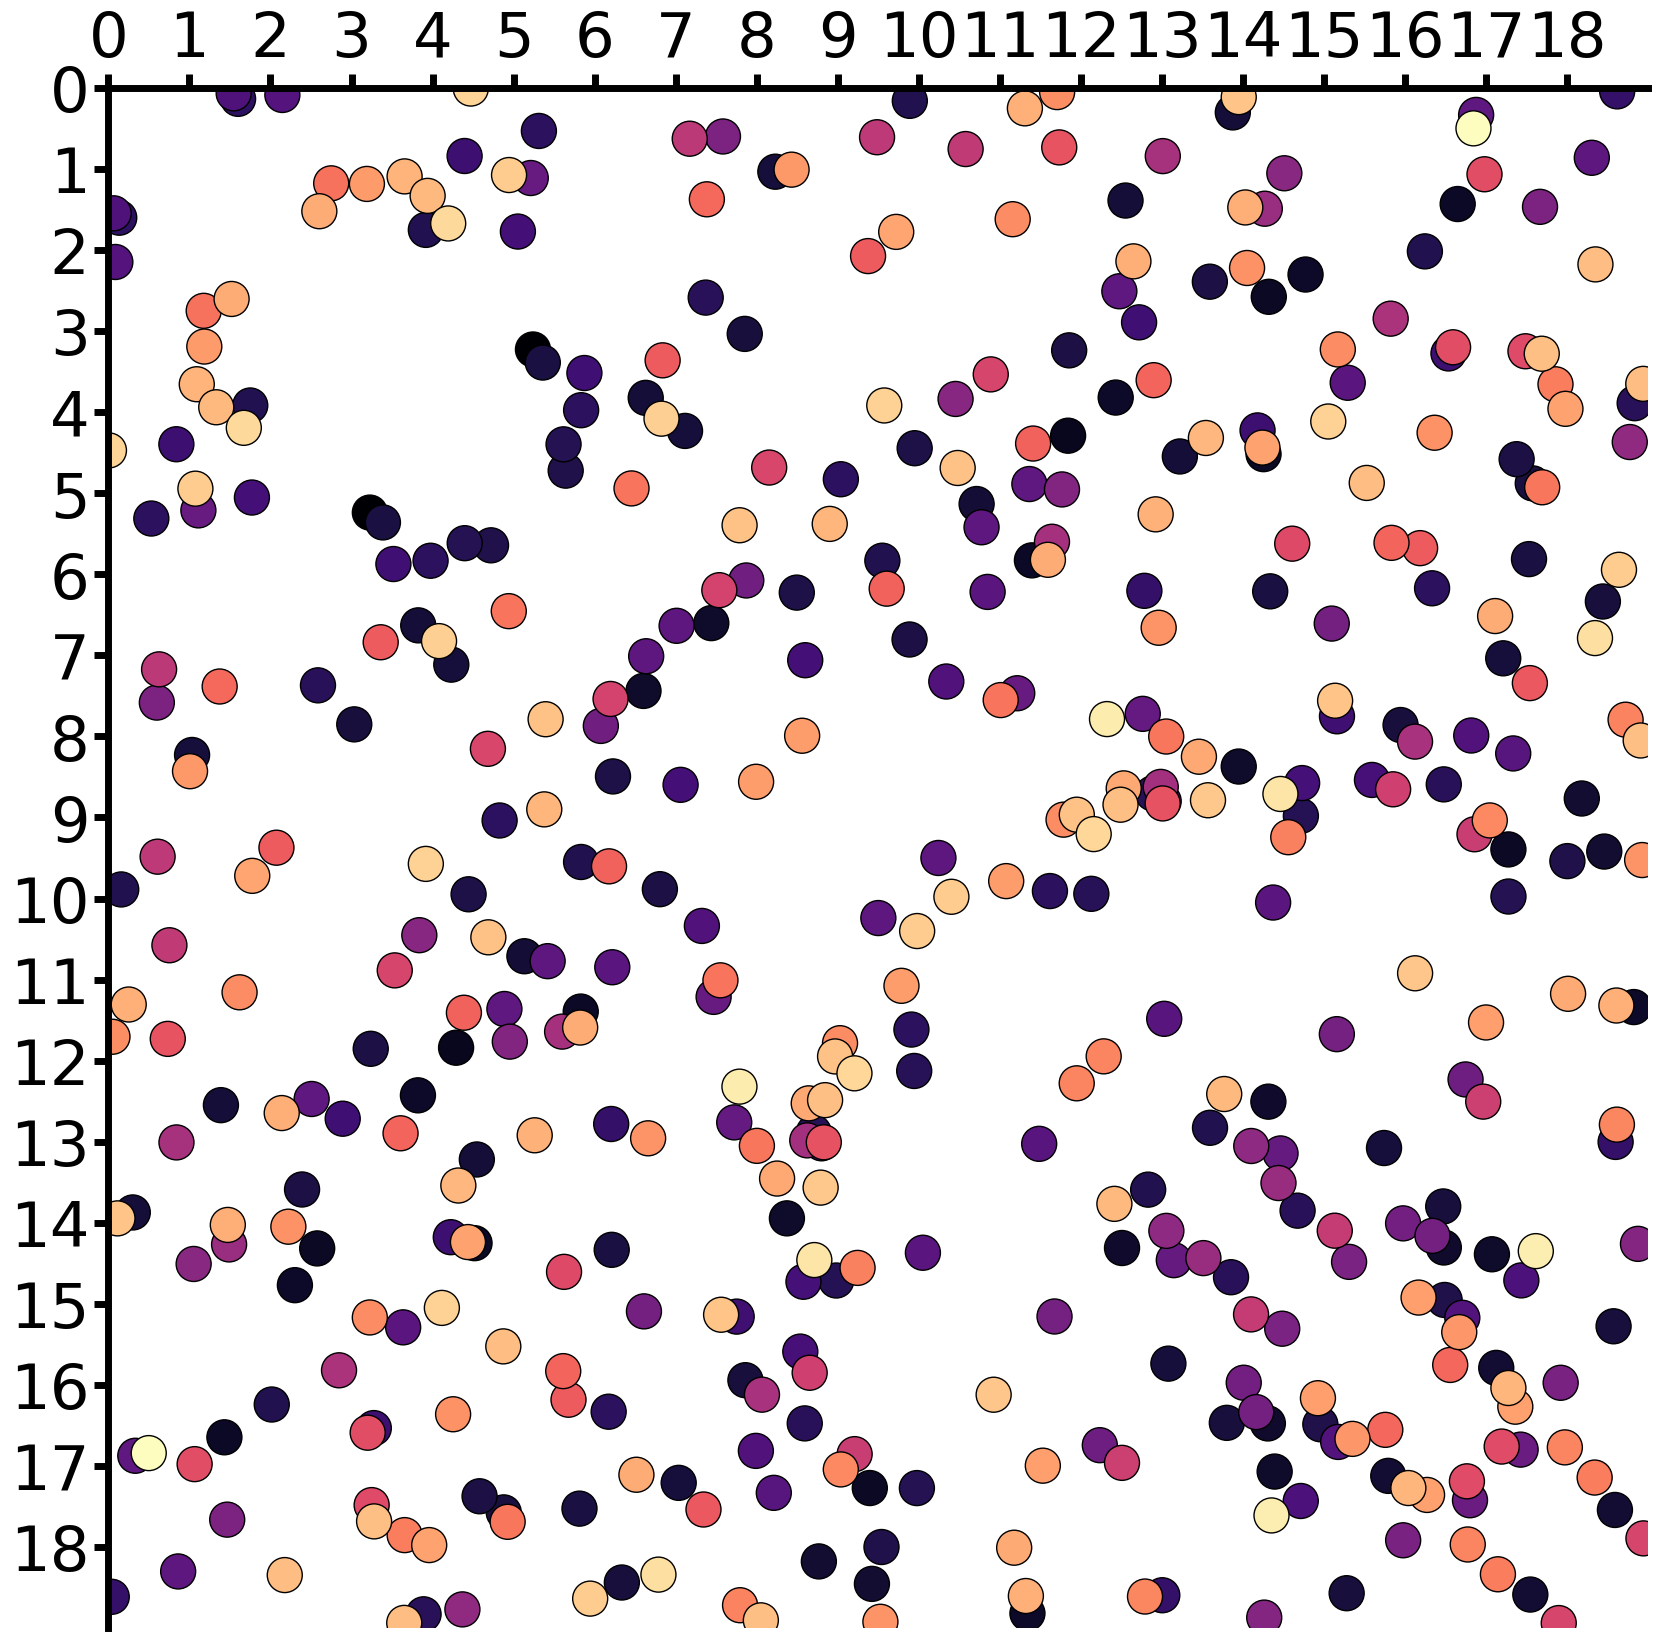

In [12]:
set_plt(figsize=(20, 20))
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
set_Border(plt.gca())

_scatter_xs, _scatter_ys = [], []
_pseudotimes = []
for rna_name in rna.obs.sort_values(by='dpt_pseudotime').index:
    if rna_name not in scHiC.keys():
        continue
    _pseudotime = rna[rna_name].obs['dpt_pseudotime'].values[0]
    _hic = array2mat(scHiC[rna_name]).copy()
    _hic += abs(_hic.min())
    
    _where = np.where(np.ones(_hic.shape))
    _where = list(zip(_where[0], _where[1]))
    _test = np.zeros(len(_where), dtype=object)
    for i in range(len(_where)):
        _test[i] = _where[i]
    _where = _test
    _p = np.triu(_hic, 1).reshape(-1)
    _p /= _p.sum()

    _scatter_x, _scatter_y = [], []
    for (i, j) in np.random.choice(_where, 1, p=_p):
        _i, _j = random.random()+i, random.random()+j
        if i == j:
            _i, _j = max(_i, _j), min(_i, _j)
        _scatter_x.append(_i)
        _scatter_y.append(_j)

    _i, _j = _scatter_x.copy(), _scatter_y.copy()
    _scatter_x.extend(_j), _scatter_y.extend(_i)

    _scatter_xs.extend(_scatter_x), _scatter_ys.extend(_scatter_y)
    _pseudotimes.extend([_pseudotime]*len(_scatter_x))

plt.scatter(_scatter_xs, _scatter_ys, edgecolors='black',
            s=(figure_size['large']*72./fig.dpi)**2, c=_pseudotimes, cmap='magma')

_len = array2mat(scHiC.get(next(iter(scHiC)))).shape[0]
plt.xticks([i for i in range(_len)])
plt.yticks([i for i in range(_len)])
plt.xlim((0, _len))
plt.ylim((0, _len))

ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('none')
ax.spines['top'].set_linewidth(figure_size['very_small'])

ax.xaxis.set_ticks_position('top')
ax.invert_yaxis()
ax.set_aspect('equal', adjustable='box')

plt.tick_params(colors='black', top=True, bottom=False, left=True, labelsize=figure_size['ultra'])
plt.grid(False)
# plt.savefig(
#     '/lmh_data/work/SEE/analyse/figure_file/{} heatmap(ODC).pdf'.format(gene_name),
#     format='pdf', bbox_inches='tight')
plt.show()

In [13]:
_partition = [
    rna.obs[rna.obs.dpt_pseudotime<=0.5],
    rna.obs[rna.obs.dpt_pseudotime>0.5]
]

pseudo_bulk_hic = []

for i in range(len(_partition)):
    _pseudo_bulk = None
    for rna_name in _partition[i].index:
        if rna_name not in scHiC.keys():
            continue

        _hic = array2mat(scHiC[rna_name]).copy()
        _hic += abs(_hic.min())
        if _pseudo_bulk is None:
            _pseudo_bulk = _hic
        else:
            _pseudo_bulk += _hic

    pseudo_bulk_hic.append(_pseudo_bulk / len(_partition[i]))
pseudo_bulk_hic

[array([[0.3474076005, 0.0555713091, 0.0201132584, 0.0322972145,
         0.027838377 , 0.0369455534, 0.0245146166, 0.0154804788,
         0.0390422638, 0.0259486796, 0.0190721791, 0.032525977 ,
         0.028995696 , 0.0260736204, 0.014830226 , 0.030516686 ,
         0.0141354672, 0.0338394729, 0.0148588487],
        [0.0555713091, 0.4088234946, 0.0354673351, 0.0273449025,
         0.0285825473, 0.0383000962, 0.0194462342, 0.025656135 ,
         0.0183019244, 0.0205263814, 0.0340790507, 0.008103532 ,
         0.0237981103, 0.0235980928, 0.0248580261, 0.0098905371,
         0.0370763349, 0.023937531 , 0.0193188678],
        [0.0201132584, 0.0354673351, 0.4356601865, 0.0135242956,
         0.0361715807, 0.0058503189, 0.0154426861, 0.0419806693,
         0.0281770471, 0.0182338559, 0.0254398578, 0.016000807 ,
         0.0332073275, 0.0289334265, 0.0345131116, 0.0266706059,
         0.0342859512, 0.0257637868, 0.0278253764],
        [0.0322972145, 0.0273449025, 0.0135242956, 0.4147322356,

In [14]:
import os
import tempfile

def _draw(mat, title=None, ignore_diag=False):
    set_plt(figsize=(10, 10))
    sns.set_theme(style="whitegrid")

    fig, ax = plt.subplots()
    
    if ignore_diag:
        mat = mat.copy()
        np.fill_diagonal(mat, 0)
    ax = sns.heatmap(mat, cmap='Greys', square=True)

    set_Border(plt.gca())
    plt.grid(False)
    
    ax.set_xticks([])
    ax.set_yticks([])

#     if title:
#         plt.savefig(
#             '/lmh_data/work/SEE/analyse/figure_file/{}.pdf'.format(title), format='pdf', bbox_inches='tight')
    plt.show()
    
def Calculate_chromatin_conformation(mat, out_dir):
    ftmp = tempfile.NamedTemporaryFile(delete=False)
    print(ftmp.name)
    with open(ftmp.name, 'w') as f:
        _strs = []
        for i in range(mat.shape[0]):
            _strs.append(','.join([str(j) for j in mat[i]])+'\n')
        f.writelines(_strs)

    os.makedirs(out_dir, exist_ok=True)
    with open('parameters.txt', 'w') as f:
        f.writelines([
            'NUM = 1\n', 'OUTPUT_FOLDER = {}\n'.format(out_dir), 'INPUT_FILE = {}\n'.format(ftmp.name),
            'VERBOSE = true\n', 'LEARNING_RATE = 1\n', 'MAX_ITERATION = 10000\n'
        ])

    os.system('java -jar /lmh_data/work/SEE/analyse/3DMax/3DMax.jar parameters.txt')

    os.remove(ftmp.name)
    os.remove('parameters.txt')

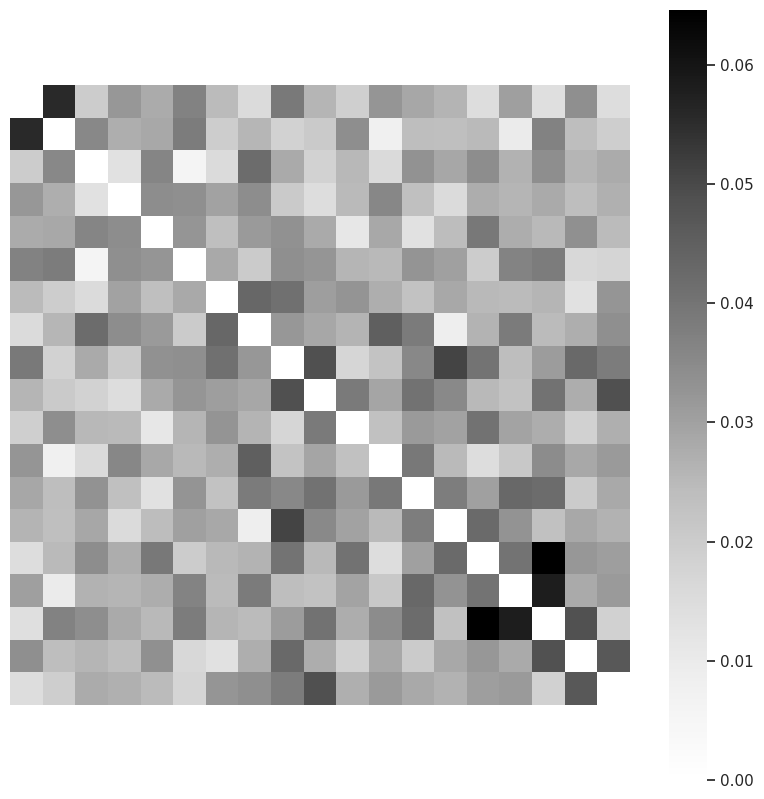

In [15]:
_draw(pseudo_bulk_hic[0], ignore_diag=True)
# Calculate_chromatin_conformation(pseudo_bulk_hic[0]*1000, 'Early')

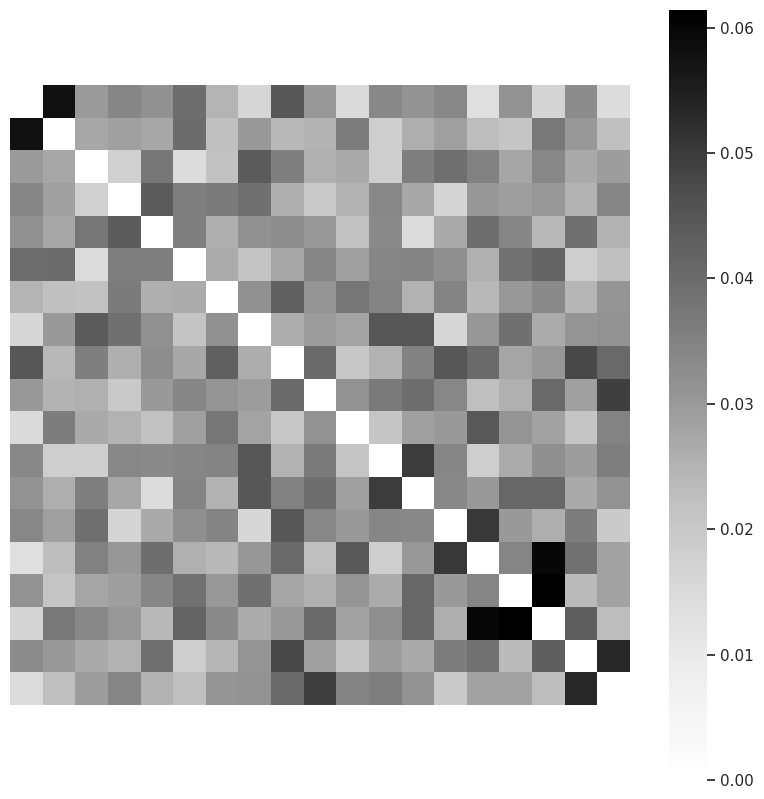

In [16]:
_draw(pseudo_bulk_hic[1], ignore_diag=True)
# Calculate_chromatin_conformation(pseudo_bulk_hic[1]*1000, 'Late')

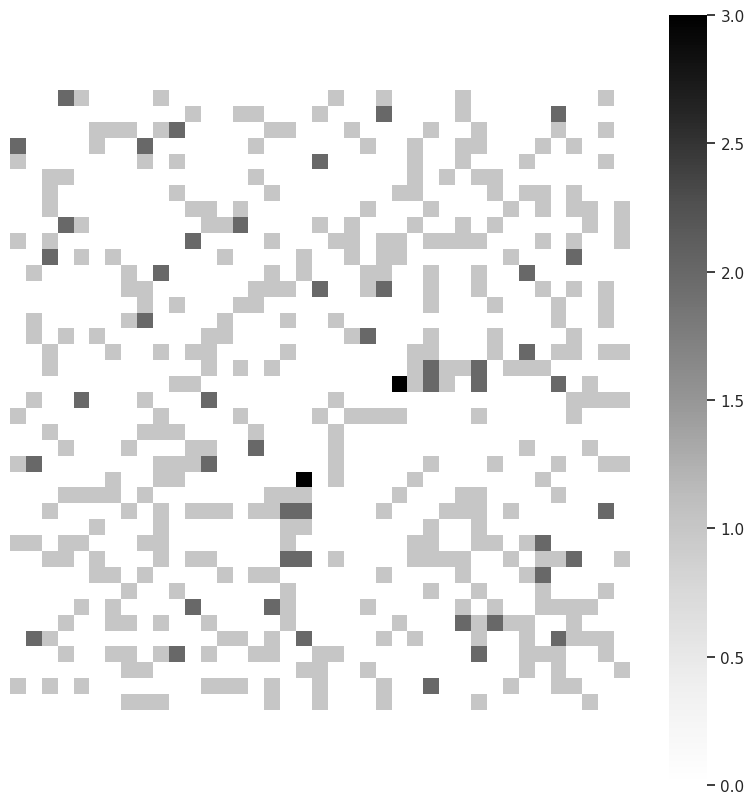

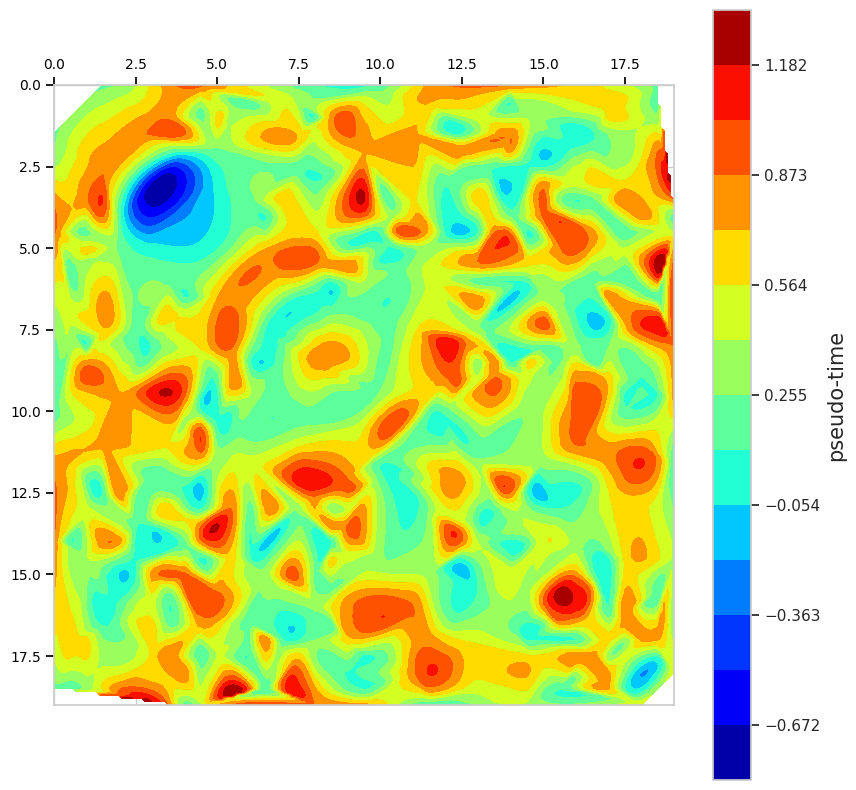

In [17]:
from scipy import interpolate

x = np.linspace(0, _len, _len*2+1)
y = np.linspace(0, _len, _len*2+1)
yy, xx = np.meshgrid(x, y)

def _norm(_decimal):
    if _decimal > 0.5:
        if 1 - _decimal >= _decimal - 0.5:
            return 0.5
        else:
            return 1
    else:
        if 0.5 - _decimal >= _decimal:
            return 0
        else:
            return 0.5

_count = np.zeros(xx.shape)
_value = np.zeros(xx.shape)
for i in range(len(_scatter_xs)):
    _decimal_x, _decimal_y = _scatter_xs[i] - int(_scatter_xs[i]), _scatter_ys[i] - int(_scatter_ys[i])
    _x, _y = int(_scatter_xs[i]) + _norm(_decimal_x), int(_scatter_ys[i]) + _norm(_decimal_y)
    _value[int(_x/0.5), int(_y/0.5)] += _pseudotimes[i]
    _count[int(_x/0.5), int(_y/0.5)] += 1

for i in range(_value.shape[0]):
    for j in range(_value.shape[1]):
        if _count[i, j] != 0:
            _value[i, j] /= _count[i, j]

_value[_count==0] = np.nan
_draw(_count, title='number of interaction occurrences({})'.format(gene_name))




set_plt(figsize=(10, 10))
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()

xx[_count==0] = yy[_count==0] = np.nan
xx, yy, new_value = xx.ravel(), yy.ravel(), _value.ravel()
xx, yy, new_value = list(xx[~np.isnan(xx)]), list(yy[~np.isnan(yy)]), list(new_value[~np.isnan(new_value)])

xnew = np.linspace(0, _len, _len*10+1)
ynew = np.linspace(0, _len, _len*10+1)
new_value = interpolate.griddata((xx, yy), new_value, (xnew[None,:], ynew[:,None]), method='cubic')

levels = np.linspace(min(new_value[~np.isnan(new_value)]), max(new_value[~np.isnan(new_value)]), 15)
cs = ax.contourf(xnew, ynew, new_value, levels=levels, cmap=plt.cm.jet)
cbar = plt.colorbar(cs)
cbar.set_label('pseudo-time', rotation=90, fontsize=15) # gas fraction

ax.xaxis.set_ticks_position('top')
ax.invert_yaxis()
ax.set_aspect('equal', adjustable='box')
plt.tick_params(colors='black', top=True, bottom=False, left=True, labelsize=figure_size['small'])

plt.savefig(
    '/lmh_data/work/SEE/analyse/figure_file/interactions distribution({}).pdf'.format(gene_name),
    format='pdf', bbox_inches='tight')

plt.show()